## Contents

- [Creating Classification Model](#Creating-Classification-Model)
- [Fitting Model to Train Data](#Fitting-Model-to-Train-Data)
- [Results](#Results)
- [Multinomial Naive Bayes vs Support Vector Classification](#Multinomial-Naive-Bayes-vs-Support-Vector-Classification)
- [Model Limitations](#Model-Limitations)
- [Conclusions & Recommendations](#Conclusions-&-Recommendations)


In [139]:
# Necessary imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import regex as re
from sklearn import metrics, svm
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (BaggingClassifier, ExtraTreesClassifier, RandomForestClassifier, 
                              AdaBoostClassifier, GradientBoostingClassifier)
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer

## Creating Classification Model

In this section, we will be trying to find and train the best model to resolve our binary classification problem - predicting the subreddit that a post belongs to. The model will consist of a vectorizer and classifier that will be selected & tuned based on several evaluation metrics, such as accuracy & ROC-AUC.

The methodology will be as follows:

1. Generate baseline model
2. Train test split
3. Instantiate multiple vectorizers & classifiers with their respective parameter grids
4. Create & fit model to training data
    - Vectorizer to transform data
    - Classifier to generate predictions
    - GridSearchCV to find best hyperparameters for each
5. Evaluate different models based on scoring metrics
6. Select top 2 models for further study    

In [2]:
data = pd.read_csv('../data/combined_clean.csv')

In [3]:
# Converting target column to numeric value
data['is_askscience'] = data['subreddit'].map(lambda x: 1 if x == 'askscience' else 0)
data.drop(columns='subreddit', inplace=True)

In [11]:
data.head()

,clean_text,is_askscience
0,read entir post care format applic appropri po...,1
1,tl dr week british scienc week answer scienc t...,1
2,graviti electromagnet quit similar forc base m...,1
3,mrna pfizer moderna ad26 j j goal vaccin make ...,1
4,virus lead cancer later life interact happen v...,1


### Baseline Model

We will be using the actual distribution of the target variable as our baseline, i.e. the accuracy score that our model ***must*** beat. This baseline can be interpreted as a 54% accuracy score when predicting all posts to be from `r/askscience`.

In [337]:
# Baseline model
data['is_askscience'].value_counts(normalize=True)

1    0.540437
0    0.459563
Name: is_askscience, dtype: float64

### Train Test Split

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    data['clean_text'],
    data['is_askscience'],
    stratify=data['is_askscience'],
    test_size=0.3,
    random_state=42
)

### Vectorizers

We will be using 3 different vectorizers to transform our text data into a form that is readable by a machine learning model.

#### Count Vectorizer

Count Vectorizer is used to transform the corpus into a vector of token counts. The raw text is converted into a numerical vector representation of words (and larger n-grams, if specified), which then makes it possible for the data to be used as features for the machine learning model. The transformed data is stored in the sparse matrix format, which greatly reduces memory usage and speeds up computation. Basically, the raw text is tokenised, then the occurences of each token are counted up.

In [154]:
# Count Vectorizer
cvec = CountVectorizer()
cvec_params = {
    'vec__ngram_range': [(1, 1), (1, 2), (2, 2)],
    'vec__max_features': [None, 5000, 2500, 1000]
}

#### Tf-idf Vectorizer

Tf-idf, or term-frequency times inverse document-frequency, is similar to CountVectorizer except that the frequency of each token is multiplied by the idf component. This acts as a pseudo-regularisation of tokens that appear very often in the corpus and may not be very meaningful when input into the machine learning model.

In [155]:
# TF-IDF Vectorizer
tvec = TfidfVectorizer()
tvec_params = {
    'vec__ngram_range': [(1, 1), (1, 2), (2, 2)],
    'vec__max_features': [None, 5000, 4000, 1000]
}

#### Hashing Vectorizer

Hashing Vectorizer serves the same purpose as Count Vectorizer (to transform raw text data into a matrix of token occurrences), except for one key difference - Hashing Vectorizer does not store the resulting vocabulary. Each token is instead mapped to a column position in a matrix via hashing. This method is more efficient for large datasets as the vocabulary is not required to be stored in memory. However, because of this, we are unable to access the actual tokens after the transformation, making the model unable to be interpreted properly.

In [156]:
# Hashing Vectorizer
hvec = HashingVectorizer()
hvec_params = {
    'vec__n_features': [2**17, 2**18, 2**19],
    'vec__ngram_range': [(1, 1), (1, 2), (2, 2)],
    'vec__norm': ['l1', 'l2']
}

### Classifiers

We will be exploring the use of 10 different classifiers.

#### Logistic Regression

Logistic Regression is a linear classification model that gives us the probabilities of being in each class by applying the logit link function to a linear regression model. Each feature is assigned a coefficient which represents the feature's weight on predicting the log-odds of success of the target variable.

In [157]:
# Logistic Regression
logreg = LogisticRegression(
    solver='liblinear',
    max_iter=1000, 
    random_state=42,
)

logreg_params = {
    'clf__penalty': ['l1', 'l2'],
    'clf__C': [0.1, 0.5, 0.75, 1, 1.5]
}

#### K Nearest Neighbors

K Nearest Neighbors (KNN) is a non-parametric model that memorises the 'locations' of each observation in relation to the each feature when fit to the training dataset. The distance between each known observation and any new unclassified point is then calculated, and the new point is assigned a class based on its proximity to other points of the each class. `k` is the hyperparameter that represents the number of closest neighbors that 'vote' on the class assignment.

In [158]:
# K Nearest Neighbors
knn = KNeighborsClassifier(n_jobs=-1)

knn_params = {
    'clf__n_neighbors': [3, 5, 7, 9],
    'clf__weights': ['uniform', 'distance'],
    'clf__p': [1, 2]
}

#### Multinomial Naive Bayes

Multinomial Naive Bayes (NB) is a classification model that relies on Bayes' theorem and the assumption that each feature in the dataset is independent of one another to classify points. The probability that an observation belongs to a specific class is calculated based on Bayes' theorem:

$$
Pr(A | B) = \frac{Pr(B | A) Pr(A)}{Pr(B)}
$$

Where `P(A)` represents the probability of the observation belonging to a specific class while `P(B)` represents the probability of observing the words in the observation. Multinomial NB is used for this classification model as the features (token occurences) are discrete.

In [159]:
# Multinomial Naive Bayes
mnb = MultinomialNB()

mnb_params = {
    'clf__alpha': np.logspace(-4, 2, 10)
}

#### Decision Tree

Decision Trees (DTs) are classification trees that begin with a root node, through which all observations are passed. The dataset is then partitioned at every internal split based on the drop in Gini impurity. DTs are fit using a greedy algorithm, meaning that they calculate the Gini impurity for every possible split at every node, thus making it a locally optimised model.

In [160]:
# Decision Tree
dt = DecisionTreeClassifier(random_state=42)

dt_params = {
    'clf__max_depth': [5, 7, 9],
    'clf__ccp_alpha': [0, 0.1, 1],
}

#### Bagging

Bagging, or Bootstrap Aggregating, is an ensemble method that bootstraps (random resampling with replacement) multiple samples from the original data, then builds a decision tree on each bootstrapped sample. The predictions are then made by passing each test observation through all the decision trees and then aggregating a prediction for that observation. This helps to reduce the overfitting problem with single DTs.

In [161]:
# Bagging
bag = BaggingClassifier(random_state=42, n_jobs=-1)

bag_params = {
    'clf__n_estimators': [5, 10, 15]
}

#### Random Forest

Random Forest goes a step further than Bagging and tries to reduce the correlation of the individual decision trees with each other by selecting a random subset of features at each split. This greatly reduces the variance of the model, at the expense of a small increase in bias, making in generally superior to full-sized bagging.

In [162]:
# Random Forest
rf = RandomForestClassifier(random_state=42, n_jobs=-1)

rf_params = {
    'clf__n_estimators': [100, 150, 200],
    'clf__max_depth': [4, 5, 6]
}

#### Extra Trees

Extra Trees, or Extremely Randomized Trees, goes even further by adding another layer of randomization in each individual decision tree. Instead of deciding the split based on the drop in Gini impurity, a random value is selected for the split (selected from the features' empirical range). This results in an additional reduction in model variance and increase in bias.

In [163]:
# Extra Trees
et = ExtraTreesClassifier(random_state=42, n_jobs=-1)

et_params = {
    'clf__n_estimators': [50, 75, 100],
    'clf__max_depth': [5, 6, 7]
}

#### Ada Boost

Ada Boost is a form of boosting, which is another ensemble method that takes a weak base learner (e.g. DT with only 1 or 2 splits) and then tries to make it a strong learner by retraining it on the misclassified samples. This is an iterative procedure that assigns weights to observations at each iteration to indicate their 'importance'. Weights are also assigned to each base model at each iteration that determines their 'say' in the final vote that would determine the model's prediction.

As boosting is an iterative procedure that cannot be parallelised, we will not go too deep into tuning the hyperparameters as it would take too long a time to do so.

In [164]:
# Ada Boost
ada = AdaBoostClassifier(
    base_estimator=DecisionTreeClassifier(), 
    random_state=42
)

ada_params = {
    'clf__base_estimator__max_depth': [1, 2],
    'clf__learning_rate': [0.8, 1]
}

#### Gradient Boost

Gradient Boost is another form of boosting that instead fits each subsequent model to the residuals of the last model. As with Ada Boost, we will only be exploring some hyperparameters for tuning.

In [165]:
# Gradient Boost
gb = GradientBoostingClassifier(random_state=42)

gb_params = {
    'clf__learning_rate': [0.1, 0.2],
    'clf__max_depth': [2, 3]
}

#### Support Vector Machine

Support Vector Machines (SVMs) are statistical models used for classification, and works by finding hyperplanes that separate linearly separable classes with maximum margin. SVM uses numerical methods to solve for decision boundaries that minimise the hinge loss. In other words, it finds the hyperplane boundary between classes that results in the least penalisation (due to misclassified or ambiguous points). SVMs are able to work with data that is not linearly separable by using different kernels that apply functions to the features.

In [166]:
# Support Vector Machine
svc = svm.SVC(random_state=42)

svc_params = {
    'clf__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'clf__C': [1, 5]
}

## Fitting Model to Train Data

We will be using a pipeline and GridSearchCV with all possible combinations of vectorizers and classifiers to create a model that will be fit to the training dataset. In this project's context, we will be optimising the hyperparameters based on accuracy.

In [153]:
# Instantiate result list
results = []

In [174]:
# Define function to model different combinations of vectorizers & classifiers, and store results
def model(vec, clf, vec_params, clf_params):
    
    # Instantiate pipeline
    pipe = Pipeline([
        ('vec', vec),
        ('clf', clf)
    ])
    
    # Scale for knn, with_mean = False to deal with sparse matrices
    if clf == knn:
        pipe = Pipeline([
            ('vec', vec),
            ('ss', StandardScaler(with_mean=False)),
            ('clf', clf)
        ])
        
    # Default vectorizer params for boosting classifiers for ease of computation
    if clf == ada or clf == gb:
        vec_params = {}
    
    # Gridsearch for best estimator
    grid = GridSearchCV(
        pipe,
        param_grid={**vec_params, **clf_params},
        scoring='accuracy',
        verbose=2,
        n_jobs=-1
    )

    grid.fit(X_train, y_train)
    
    print(f'{vec}: {clf}')
    print('Best Parameters:')
    print(grid.best_params_)
    
    # Scoring metrics
    scores = {'Vectorizer': vec, 'Classifier': clf}
    y_preds = grid.predict(X_test)
    scores['Train Accuracy Score'] = grid.score(X_train, y_train)
    scores['Test Accuracy Score'] = metrics.accuracy_score(y_test, y_preds)
    scores['F1'] = metrics.f1_score(y_test, y_preds)
    scores['Precision'] = metrics.precision_score(y_test, y_preds)
    scores['Recall'] = metrics.recall_score(y_test, y_preds)
    scores['ROC-AUC'] = metrics.roc_auc_score(y_test, y_preds)
    
    # Storing results
    
    results.append(scores)
    
    return pipe

In [168]:
vectorizers = [
    (cvec, cvec_params),
    (tvec, tvec_params),
    (hvec, hvec_params)
]

In [169]:
classifiers = [
    (logreg, logreg_params),
    (knn, knn_params),
    (mnb, mnb_params),
    (dt, dt_params),
    (bag, bag_params),
    (rf, rf_params),
    (et, et_params),
    (ada, ada_params),
    (gb, gb_params),
    (svc, svc_params)
]

In [170]:
for (vec, vec_params) in vectorizers:
    for (clf, clf_params) in classifiers:
        # MNB Classifier cannot take in negative X values from hvec
        if not(vec == hvec and clf == mnb):
            model(vec, clf, vec_params, clf_params)

Fitting 5 folds for each of 120 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   22.5s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:   45.6s finished


LogisticRegression(max_iter=1000, random_state=42, solver='liblinear')
Best Parameters:
{'clf__C': 0.5, 'clf__penalty': 'l2', 'vec__max_features': None, 'vec__ngram_range': (1, 1)}
Fitting 5 folds for each of 192 candidates, totalling 960 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   16.3s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   38.1s
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 960 out of 960 | elapsed:  1.7min finished


KNeighborsClassifier(n_jobs=-1)
Best Parameters:
{'clf__n_neighbors': 3, 'clf__p': 2, 'clf__weights': 'distance', 'vec__max_features': 1000, 'vec__ngram_range': (1, 2)}
Fitting 5 folds for each of 120 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 178 tasks      | elapsed:   13.7s
[Parallel(n_jobs=-1)]: Done 381 tasks      | elapsed:   30.8s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:   48.4s finished


MultinomialNB()
Best Parameters:
{'clf__alpha': 1.0, 'vec__max_features': 5000, 'vec__ngram_range': (1, 1)}
Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   12.9s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   30.7s
[Parallel(n_jobs=-1)]: Done 540 out of 540 | elapsed:   48.3s finished


DecisionTreeClassifier(random_state=42)
Best Parameters:
{'clf__ccp_alpha': 0, 'clf__max_depth': 9, 'vec__max_features': 2500, 'vec__ngram_range': (1, 2)}
Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   12.5s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  1.6min finished


BaggingClassifier(n_jobs=-1, random_state=42)
Best Parameters:
{'clf__n_estimators': 5, 'vec__max_features': 5000, 'vec__ngram_range': (1, 2)}
Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   40.2s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 540 out of 540 | elapsed:  2.5min finished


RandomForestClassifier(n_jobs=-1, random_state=42)
Best Parameters:
{'clf__max_depth': 6, 'clf__n_estimators': 150, 'vec__max_features': 1000, 'vec__ngram_range': (1, 1)}
Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   24.4s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   58.7s
[Parallel(n_jobs=-1)]: Done 540 out of 540 | elapsed:  1.5min finished


ExtraTreesClassifier(n_jobs=-1, random_state=42)
Best Parameters:
{'clf__max_depth': 7, 'clf__n_estimators': 75, 'vec__max_features': 1000, 'vec__ngram_range': (1, 2)}
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 out of  20 | elapsed:    6.4s remaining:    1.5s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    7.9s finished


AdaBoostClassifier(base_estimator=DecisionTreeClassifier(), random_state=42)
Best Parameters:
{'clf__base_estimator__max_depth': 2, 'clf__learning_rate': 1}
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 out of  20 | elapsed:    7.5s remaining:    1.8s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    8.9s finished


GradientBoostingClassifier(random_state=42)
Best Parameters:
{'clf__learning_rate': 0.2, 'clf__max_depth': 3}
Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   32.6s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed:  1.5min finished


SVC(random_state=42)
Best Parameters:
{'clf__C': 1, 'clf__kernel': 'linear', 'vec__max_features': None, 'vec__ngram_range': (1, 1)}
Fitting 5 folds for each of 120 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   14.3s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   32.6s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:   54.4s finished


LogisticRegression(max_iter=1000, random_state=42, solver='liblinear')
Best Parameters:
{'clf__C': 1, 'clf__penalty': 'l2', 'vec__max_features': 4000, 'vec__ngram_range': (1, 1)}
Fitting 5 folds for each of 192 candidates, totalling 960 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   16.3s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   38.1s
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 960 out of 960 | elapsed:  1.7min finished


KNeighborsClassifier(n_jobs=-1)
Best Parameters:
{'clf__n_neighbors': 3, 'clf__p': 2, 'clf__weights': 'distance', 'vec__max_features': None, 'vec__ngram_range': (1, 1)}
Fitting 5 folds for each of 120 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 178 tasks      | elapsed:   14.4s
[Parallel(n_jobs=-1)]: Done 381 tasks      | elapsed:   31.8s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:   50.6s finished


MultinomialNB()
Best Parameters:
{'clf__alpha': 0.21544346900318823, 'vec__max_features': None, 'vec__ngram_range': (1, 2)}
Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   13.6s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   32.9s
[Parallel(n_jobs=-1)]: Done 540 out of 540 | elapsed:   53.1s finished


DecisionTreeClassifier(random_state=42)
Best Parameters:
{'clf__ccp_alpha': 0, 'clf__max_depth': 9, 'vec__max_features': None, 'vec__ngram_range': (1, 2)}
Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   13.7s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  1.7min finished


BaggingClassifier(n_jobs=-1, random_state=42)
Best Parameters:
{'clf__n_estimators': 15, 'vec__max_features': None, 'vec__ngram_range': (1, 1)}
Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   35.8s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 540 out of 540 | elapsed:  2.3min finished


RandomForestClassifier(n_jobs=-1, random_state=42)
Best Parameters:
{'clf__max_depth': 6, 'clf__n_estimators': 100, 'vec__max_features': 1000, 'vec__ngram_range': (1, 1)}
Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   21.9s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   53.4s
[Parallel(n_jobs=-1)]: Done 540 out of 540 | elapsed:  1.4min finished


ExtraTreesClassifier(n_jobs=-1, random_state=42)
Best Parameters:
{'clf__max_depth': 7, 'clf__n_estimators': 100, 'vec__max_features': 1000, 'vec__ngram_range': (1, 1)}
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 out of  20 | elapsed:    2.9s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    4.3s finished


AdaBoostClassifier(base_estimator=DecisionTreeClassifier(), random_state=42)
Best Parameters:
{'clf__base_estimator__max_depth': 1, 'clf__learning_rate': 0.8}
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 out of  20 | elapsed:    6.8s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    7.9s finished


GradientBoostingClassifier(random_state=42)
Best Parameters:
{'clf__learning_rate': 0.2, 'clf__max_depth': 3}
Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   27.3s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed:  1.4min finished


SVC(random_state=42)
Best Parameters:
{'clf__C': 1, 'clf__kernel': 'linear', 'vec__max_features': None, 'vec__ngram_range': (1, 2)}
Fitting 5 folds for each of 180 candidates, totalling 900 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 186 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-1)]: Done 389 tasks      | elapsed:   33.6s
[Parallel(n_jobs=-1)]: Done 672 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 900 out of 900 | elapsed:  1.6min finished


LogisticRegression(max_iter=1000, random_state=42, solver='liblinear')
Best Parameters:
{'clf__C': 1.5, 'clf__penalty': 'l2', 'vec__n_features': 131072, 'vec__ngram_range': (1, 1), 'vec__norm': 'l2'}
Fitting 5 folds for each of 288 candidates, totalling 1440 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   16.9s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   33.1s
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:  2.3min finished


KNeighborsClassifier(n_jobs=-1)
Best Parameters:
{'clf__n_neighbors': 3, 'clf__p': 2, 'clf__weights': 'distance', 'vec__n_features': 131072, 'vec__ngram_range': (1, 1), 'vec__norm': 'l1'}
Fitting 5 folds for each of 162 candidates, totalling 810 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   18.9s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   51.1s
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 810 out of 810 | elapsed:  2.0min finished


DecisionTreeClassifier(random_state=42)
Best Parameters:
{'clf__ccp_alpha': 0, 'clf__max_depth': 9, 'vec__n_features': 262144, 'vec__ngram_range': (1, 2), 'vec__norm': 'l1'}
Fitting 5 folds for each of 54 candidates, totalling 270 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   29.9s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed: 17.8min finished


BaggingClassifier(n_jobs=-1, random_state=42)
Best Parameters:
{'clf__n_estimators': 15, 'vec__n_features': 262144, 'vec__ngram_range': (1, 1), 'vec__norm': 'l2'}
Fitting 5 folds for each of 162 candidates, totalling 810 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   24.7s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 810 out of 810 | elapsed:  3.4min finished


RandomForestClassifier(n_jobs=-1, random_state=42)
Best Parameters:
{'clf__max_depth': 6, 'clf__n_estimators': 200, 'vec__n_features': 131072, 'vec__ngram_range': (1, 2), 'vec__norm': 'l2'}
Fitting 5 folds for each of 162 candidates, totalling 810 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   45.1s
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 810 out of 810 | elapsed:  1.9min finished


ExtraTreesClassifier(n_jobs=-1, random_state=42)
Best Parameters:
{'clf__max_depth': 7, 'clf__n_estimators': 50, 'vec__n_features': 131072, 'vec__ngram_range': (1, 2), 'vec__norm': 'l2'}
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 out of  20 | elapsed:   56.5s remaining:   14.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  1.3min finished


AdaBoostClassifier(base_estimator=DecisionTreeClassifier(), random_state=42)
Best Parameters:
{'clf__base_estimator__max_depth': 2, 'clf__learning_rate': 0.8}
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 out of  20 | elapsed:  2.3min remaining:   35.1s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  2.9min finished


GradientBoostingClassifier(random_state=42)
Best Parameters:
{'clf__learning_rate': 0.2, 'clf__max_depth': 3}
Fitting 5 folds for each of 144 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   18.9s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   45.6s
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed:  1.6min finished


SVC(random_state=42)
Best Parameters:
{'clf__C': 1, 'clf__kernel': 'sigmoid', 'vec__n_features': 262144, 'vec__ngram_range': (1, 2), 'vec__norm': 'l1'}


## Results

In [184]:
# Ranking different models by test accuracy score
model_results = pd.DataFrame(results)\
.sort_values(by='Test Accuracy Score', ascending=False).reset_index(drop=True)

In [185]:
model_results

,Vectorizer,Classifier,Train Accuracy Score,Test Accuracy Score,F1,Precision,Recall,ROC-AUC
0,TfidfVectorizer(),MultinomialNB(),1.000000,0.958106,0.960549,0.979021,0.942761,0.959476
1,CountVectorizer(),MultinomialNB(),0.983607,0.948998,0.951220,0.985560,0.919192,0.951659
2,TfidfVectorizer(),SVC(random_state=42),1.000000,0.943534,0.948074,0.943333,0.952862,0.942701
3,HashingVectorizer(),SVC(random_state=42),0.984387,0.927140,0.932886,0.929766,0.936027,0.926347
4,TfidfVectorizer(),"LogisticRegression(max_iter=1000, random_state...",0.985168,0.918033,0.927066,0.893750,0.962963,0.914021
5,HashingVectorizer(),"LogisticRegression(max_iter=1000, random_state...",0.978142,0.914390,0.924559,0.883436,0.969697,0.909452
6,CountVectorizer(),"LogisticRegression(max_iter=1000, random_state...",0.999219,0.907104,0.918138,0.877301,0.962963,0.902116
7,CountVectorizer(),SVC(random_state=42),1.000000,0.897996,0.908497,0.882540,0.936027,0.894601
8,HashingVectorizer(),GradientBoostingClassifier(random_state=42),0.983607,0.863388,0.882995,0.822674,0.952862,0.855399
9,TfidfVectorizer(),GradientBoostingClassifier(random_state=42),0.986729,0.854281,0.875389,0.814493,0.946128,0.846080


### Metrics

As can be seen from the results table above, we have evaluated each model on 6 metrics:
1. Train Accuracy Score: Accuracy of model at predicting train dataset
2. Test Accuracy Score: Accuracy of model at predicting test dataset (**Main Criteria**)
3. F1 Score: Weighted average of precision and recall
4. Precision: Positive Predictive Value (True Positives / Total Positive Predictions)
5. Recall: Sensitivity or True Positive Rate (True Positives / Total Actual Positives)
6. ROC-AUC Score: Area under the Receiver Operating Characteristic Curve from prediction scores

In the context of this project, we are dealing with a binary classification problem between two subreddits of equal importance to us. Thus, a positive or negative prediction does not really matter, as long as it is correct. Thus, we will be focusing on the accuracy score and ROC-AUC score from here onwards.

### Vectorizer Average Scores

| Vectorizer         | Train Accuracy Score | Test Accuracy Score | ROC-AUC |
|--------------------|----------------------|---------------------|---------|
| Tfidf Vectorizer   | 0.942                | 0.842               | 0.833   |
| Count Vectorizer   | 0.940                | 0.830               | 0.821   |
| Hashing Vectorizer | 0.904                | 0.777               | 0.761   |

Tfidf Vectorizer generally performed the best, followed closely by Count Vectorizer, then Hashing Vectorizer quite far behind. Hashing Vectorizer probably performed the worse due to its particularly poor performance in conjunction with Random Forest, Extra Trees & KNN (Bottom 3 performing models, wrost one even barely beating the baseline model). Generally, Tfidf & Count Vectorizer performed quite similarly to each other, but the regularisation of overly common words probably helped improved the performance for Tfidf Vectorizer models slightly more.

### Classifier Average Scores

| Classifier                    |          | Train Accuracy Score | Test Accuracy Score | ROC-AUC |
|-------------------------------|----------|----------------------|---------------------|---------|
| Multinomial Naïve Bayes       | `mnb`    | 0.992                | 0.954               | 0.956   |
| Support Vector Classification | `svc`    | 0.995                | 0.923               | 0.921   |
| Logistic Regression           | `logreg` | 0.988                | 0.913               | 0.909   |
| Gradient Boost                | `gb`     | 0.978                | 0.856               | 0.848   |
| Bagging                       | `bag`    | 0.987                | 0.846               | 0.842   |
| Ada Boost                     | `ada`    | 0.960                | 0.834               | 0.830   |
| Decision Tree                 | `dt`     | 0.850                | 0.792               | 0.781   |
| Random Forest                 | `rf`     | 0.800                | 0.752               | 0.731   |
| Extra Trees                   | `et`     | 0.769                | 0.705               | 0.680   |
| K Nearest Neighbors           | `knn`    | 1.000                | 0.645               | 0.619   |

Most of the models actually performed quite well, with 3 models even achieving >90% accuracy scores. Some notable observations:
- `knn` actually had perfect train accuracy scores with all 3 vectorizers, but the worst test accuracy score, thus indicating a very low bias but high variance (i.e. an overfit model)
- Surprisingly, `dt` performed better than `rf` and `et` in both bias and variance metrics. This could be due to better hyperparameter tuning for `dt`
- `mnb`, `svc` and `logreg` all performed exceedingly well on both the train and test sets
- ROC-AUC Score had the same rankings as test accuracy score
- `gb` and `ada` performd quite well (>80% test accuracy) despite limited model tuning. With greater computation power to tune more hyperparameters, perhaps these classifiers could even outperform the top few

## Multinomial Naive Bayes vs Support Vector Classification

Here, we will be exploring the two best performing models further.

In [210]:
# Top 2 Models
model_results.iloc[[0,2]].drop(columns=['F1', 'Precision', 'Recall']).reset_index(drop=True)

,Vectorizer,Classifier,Train Accuracy Score,Test Accuracy Score,ROC-AUC
0,TfidfVectorizer(),MultinomialNB(),1.0,0.958106,0.959476
1,TfidfVectorizer(),SVC(random_state=42),1.0,0.943534,0.942701


As can be seen above, both models had perfect train accuracy scores and very high test accuracy scores, as well as ROC-AUC scores. These models perform extremely well in classifying the subreddit posts. Both models implemented the Tfidf Vectorizer with identical hyperparameters (`ngram_range = (1,2)`). `mnb` slightly edges `svc` for both metrics, although the difference is quite small.

### Confusion Matrix

A confusion matrix is a good way to visualise how many samples from each class got predicted correctly / wrongly. 

![confusion_matrix](../images/confusion_matrix_explanation.png "Confusion Matrix")


In the context of this project, the different outcomes can be explained as such:
- **TN**: Belongs to `r/AskSocialScience`, predicted `r/AskSocialScience`
- **FP**: Belongs to `r/AskSocialScience`, predicted `r/AskScience`
- **FN**: Belongs to `r/AskScience`, predicted `r/AskSocialScience`
- **TP**: Belongs to `r/AskScience`, predicted `r/AskScience`

As mentioned earlier, for the context of this project, there is no real difference between Type I and Type II error. We are more interested in the actual numbers in each quadrant.

In [254]:
# Creating bag-of-words
final_vec = TfidfVectorizer(ngram_range=(1, 2))
X_train_tvec = final_vec.fit_transform(X_train)
X_test_tvec = final_vec.transform(X_test)

In [255]:
# Best MNB model
final_mnb = MultinomialNB(alpha=0.21544346900318823)
final_mnb.fit(X_train_tvec, y_train)

MultinomialNB(alpha=0.21544346900318823)

In [256]:
# Best SVC model
final_svc = svm.SVC(kernel='linear')
final_svc.fit(X_train_tvec, y_train)

SVC(kernel='linear')

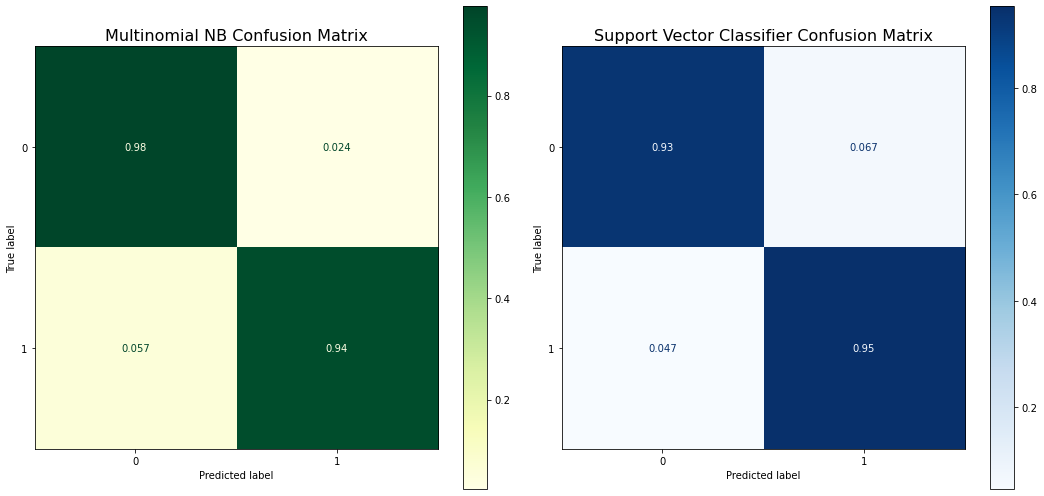

In [347]:
# Plotting confusion matrices
fig, ax = plt.subplots(1, 2, figsize=(15,7))
ax = ax.ravel()

metrics.plot_confusion_matrix(
    final_mnb,
    X_test_tvec,
    y_test,
    normalize='true',
    cmap='YlGn',
    ax=ax[0]
)
ax[0].set_title('Multinomial NB Confusion Matrix', fontsize=16)

metrics.plot_confusion_matrix(
    final_svc,
    X_test_tvec,
    y_test,
    normalize='true',
    cmap='Blues',
    ax=ax[1]
)
ax[1].set_title('Support Vector Classifier Confusion Matrix', fontsize=16)

fig.tight_layout()

As can be seen from the respective confusion matrices, there is not much difference between the two models. `mnb` was better at correctly predicting posts from `r/AskSocialScience`, while `svc` was slightly better at correctly predicting posts from `r/AskScience`.

### ROC-AUC Curve

We can also plot the ROC-AUC Curve to better visualise how 'separated' the distributions are for each model. The area under the ROC-AUC curve represents the gap between distributions of each subreddit.

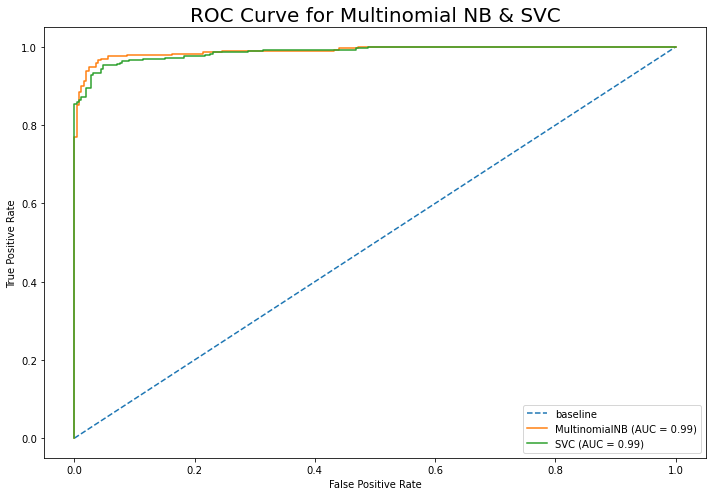

In [238]:
fig, ax = plt.subplots(1, 1, figsize=(10,7))

# Baseline plot (Perfect overlap between both positive & negative distributions)
plt.plot(
    np.linspace(0, 1, 200),
    np.linspace(0, 1, 200),
    label='baseline',
    linestyle='--'
)

# MNB ROC Curve
metrics.plot_roc_curve(
    final_mnb,
    X_test_tvec,
    y_test,
    ax=ax
)

# SVC ROC Curve
metrics.plot_roc_curve(
    final_svc,
    X_test_tvec,
    y_test,
    ax=ax
)

plt.title('ROC Curve for Multinomial NB & SVC', fontsize=20)
plt.tight_layout()

As seen from above, once again there is barely any difference between the two models. Both perform extremely well with ROC-AUC scores of 0.99. However, from the plot, we can see that `mnb` performs slightly better at lower decision thresholds.

### Model Interpretation

Another area we can look at is the interpretability of the models. So far, we have been evaluating the predictive value of the models. However, classification models that are good for inference can also prove useful to stakeholders such as the subreddit moderators.

#### Multinomial Naive Bayes

One great aspect of `mnb` is that we are able to extract the feature importance from the model and rank them accordingly for each subreddit.

In [351]:
# Extracting top 15 important features for each subreddit
pos_class_prob_sorted = final_mnb.feature_log_prob_[1, :].argsort()[::-1]
neg_class_prob_sorted = final_mnb.feature_log_prob_[0, :].argsort()[::-1]

print('Top 15 Important Features for r/AskScience:')
print(np.take(final_vec.get_feature_names(), pos_class_prob_sorted[:15]))
print('')
print('Top 15 Important Features for r/AskSocialScience:')
print(np.take(final_vec.get_feature_names(), neg_class_prob_sorted[:15]))


Top 15 Important Features for r/AskScience:
['vaccin' 'covid' 'differ' 'earth' 'viru' 'cell' 'water' 'immun' 'effect'
 'peopl' 'possibl' 'make' 'light' 'time' 'human']

Top 15 Important Features for r/AskSocialScience:
['peopl' 'social' 'studi' 'cultur' 'research' 'countri' 'societi'
 'american' 'read' 'think' 'person' 'polit' 'theori' 'book' 'thing']


From this, we are able to compare the top important features with the most frequent words that we explored during the EDA earlier.

| Rank | r/AskScience |                    | r/AskSocialScience |                    |
|------|--------------|--------------------|--------------------|--------------------|
|      | **Frequency**    | **Feature Importance** | **Frequency**          | **Feature Importance** |
| 1    | vaccin       | vaccin             | peopl              | peopl              |
| 2    | covid        | covid              | social             | social             |
| 3    | differ       | differ             | studi              | studi              |
| 4    | peopl        | earth              | cultur             | cultur             |
| 5    | make         | viru               | research           | research           |
| 6    | time         | cell               | countri            | countri            |
| 7    | understand   | water              | differ             | societi            |
| 8    | cell         | immun              | time               | american           |
| 9    | effect       | effect             | think              | read               |
| 10   | work         | peopl              | thing              | think              |
| 11   | mean         | possibl            | exampl             | person             |
| 12   | viru         | make               | read               | polit              |
| 13   | say          | light              | american           | theori             |
| 14   | earth        | time               | person             | book               |
| 15   | possibl      | human              | make               | thing              |

Some interesting things to note from the comparison:
- Generally, top few most frequent words are still the most predictive
- Generic words (e.g. `make`, `understand`, `thing`) tend to drop off in feature importance as compared to their frequency
- Some words are still important in predicting both classes despite appearing in both lists (e.g. `peopl`), which suggests that features need not always point to one specific class

#### Support Vector Classifier 

On the other hand, `svc` is generally a black-box model, especially when implementing non-linear kernels such as polynomial and gaussian. It is difficult to interpret the coefficients from the model, which makes it worse at inference despite its good predictive performance.

In [279]:
# List of coefficients for SVC model
list(final_svc.coef_.toarray()[0])

[0.1574135580858934,
 0.05035385805822142,
 0.03592094998174063,
 0.03592094998174063,
 0.03592094998174063,
 0.06233297046146063,
 -0.04458539819208144,
 0.3238225012413873,
 0.3190075428948135,
 0.0,
 -0.01728401698331917,
 -0.08080715576581932,
 0.0009023905349321639,
 0.0018047810698643277,
 0.0,
 -0.019883999230064876,
 0.057333302951536456,
 0.0,
 0.0,
 0.13266850421854717,
 0.0,
 0.0,
 0.01204769770059163,
 0.01204769770059163,
 0.05035385805822142,
 0.05035385805822142,
 0.07096474307044069,
 0.0,
 0.0,
 0.07504174836558415,
 0.0,
 0.0,
 0.02330846161354894,
 0.02330846161354894,
 0.16734772845204057,
 -0.03514868427866273,
 0.0,
 -0.029111647102249956,
 -0.017023942057793867,
 0.0,
 0.0,
 0.0,
 0.1378732533387008,
 0.0,
 0.04291673346399574,
 -0.007330278875334225,
 0.0,
 0.0,
 0.08360477585544351,
 -0.05289655563353358,
 -0.04751820394431691,
 0.0,
 0.08766863619167965,
 0.0,
 0.0552736139153143,
 0.0,
 -0.020427302542327285,
 -0.020427302542327285,
 0.0,
 0.0,
 0.0,
 -0.1072

For a general kernel, it is difficult to interpret the SVM weights. However, in the case of our two models (linear SVC), there actually is a useful interpretation:

>The coefficients represent the coordinates of a vector which is orthogonal to the hyperplane which separates the classes as best as possible.
>
>With this vector, we can take its dot product with any new point and interpret it as such: If the dot product is positive, it belongs to the positive class, if it is negative it belongs to the negative class.
>
>The importance of each feature can also be estimated by studying the absolute size of its coefficient relative to all the others.

### Best Model

By all comparisons, `mnb` with `Tfidf Vectorizer` edges out `svc` as the better model, both for predictive performance & inferential value.

## Model Limitations

Despite the great scores, no model is perfect. We will evaluate our model to see which areas are lacking.

### Misclassified Posts

We can examine misclassified posts to find any weaknesses in our model. We will use `mnb` for these final predictions.

In [363]:
# Comparing predicted classifications to actual subreddits
model_check = pd.DataFrame(final_mnb.predict(X_test_tvec), columns=['pred'])
model_preds = pd.DataFrame(final_mnb.predict_proba(X_test_tvec), columns=['prob_socsci', 'prob_sci'])
model_check = model_check.join(model_preds)
model_check = model_check.join(y_test.reset_index())

In [364]:
model_check

,pred,prob_socsci,prob_sci,index,is_askscience
0,1,0.263944,0.736056,477,1
1,1,0.175433,0.824567,728,1
2,0,0.973111,0.026889,1003,0
3,0,0.949183,0.050817,1009,0
4,1,0.186830,0.813170,103,1
...,...,...,...,...,...
544,0,0.703571,0.296429,1473,0
545,0,0.754031,0.245969,1634,0
546,1,0.036928,0.963072,549,1
547,1,0.229482,0.770518,294,1


In [365]:
# Misclassified posts
model_check[model_check['pred'] != model_check['is_askscience']]

,pred,prob_socsci,prob_sci,index,is_askscience
84,0,0.658496,0.341504,852,1
117,0,0.514766,0.485234,131,1
120,1,0.351676,0.648324,1544,0
137,0,0.513043,0.486957,458,1
144,0,0.785796,0.214204,634,1
146,1,0.383292,0.616708,1095,0
183,0,0.609846,0.390154,881,1
192,0,0.771974,0.228026,167,1
195,1,0.432752,0.567248,1332,0
207,1,0.494523,0.505477,1390,0


#### Close Calls

As can be seen, many of the misclassified posts are 'close calls', i.e. the model assigned probabilities for each subreddit that were close to each other. Let us examine one such case:

In [336]:
data_raw = pd.read_csv('../data/combined_raw.csv')

In [373]:
# False Negative: Predicted r/AskSocialScience, belongs to r/AskScience
print(data_raw.iloc[458, [1,2]]['title'])
print(data_raw.iloc[458, [1,2]]['selftext'])

Why is the Cardia (oesophagus-stomach opening) named so?
 I'm curious about the linguistics (?) and the reasoning behind whoever named that region, considering that everything heart-related is "cardiac," but just recently I learned that anything related to the Cardia is also "cardiac".

They both seem to be from the Greek word "kardia" (heart) according to Merriam Webster, so I'm curious if something got lost in translation or if the scientist naming that region just decided to be funny.


This is a good example of a post that would throw off our model. The post is discussing a scientific topic - biological organs (`cardiac`). However, the context of the question is that of social science - the linguistics behind the name of the biological organ. Posts like these could easily belong to either subreddit and fit in. Our model is unable to understand the intricacies and semantics that clue us as to where the post actually belongs, it is only able to pick up on the key words or tokens that signal to the model how it should be classified.

#### Completely Wrong

On the other hand, there are some posts with which our model was way off in predicting the classification probability. Let us examine such a post:

In [374]:
# False Positive: Predicted r/AskScience, belongs to r/AskSocialScience
print(data_raw.iloc[1268, [1,2]]['title'])
print(data_raw.iloc[1268, [1,2]]['selftext'])

Is climate change boosting development of mountainous regions and therefor of more mountainous countries?
Looking at constant decrease of snow got me wondering: Is proportion of tourists in areas where there's substantial amount of snow cover (mountainous and northern regions) increasing as a result? I for one would've loved to see Paris during winter, but seeing that there's no snow made snowy areas more lucrative for me as I could visit Paris at any time of year and the experience wouldn't be very different.

How do you think will that develop mountainous rural areas and countries which are covered with those areas to substantial amount, like Switzerland or Austria?


This is another good example of a post that would throw off our model - the post is clearly a question on social impact (development of mountainous regions). However, the premise of the question has to do with a concept that strongly signals to `r/AskScience` - climate change. There are more words relating to climate change than there are relating to development, even though the focus of the question is on development. Our model is unable to understand the semantics behind the question as a whole and thus classifies it wrongly.

### Further Improvements

The first and foremost improvement would be, of course, to gather more data. Reddit API's limitations of 1000 posts constrains us to a limited dataset. Furthermore, the timespan of posts is also constrained and the data may thus be affected by certain events that do not consistently happen. For instance, our model showed us that the main features that predicted `r/AskScience` were related to Covid 19. However, this was definitely not the case before the year 2020, and perhaps our model would perform very differently if given the subreddit data for a much longer time frame.

We could also try and incorporate more semantic concepts into our model such as a measure of sentiment analysis to help add another feature to classify posts. As shown above, solely relying on a bag-of-words model leads to some weaknesses in the model when it cannot detect underlying implications or semantics of a post.

## Conclusions & Recommendations

Going back to our problem statement in the beginning, we have successfully created an effective classification model using NLP techniques. Our final model incorporating the `Tfidf Vectorizer` and the `Multinomial Naive Bayes Classifier` delivered great results in terms of classifying posts correctly, indicating high predictive performance. The model was also good for inference, as we were able to extract the feature importances from the model.

While the actual predictions may not provide much value to Reddit moderators (since the posts by default have to belong to a subreddit), the classification probabilities and feature importances can be helpful for moderators of these subreddits to look at the underlying characteristics of posts. They can use these inferences to shape their moderation policies and influence the direction of the subreddit. For example, the `r/AskScience` moderators could discover that Covid-19 posts are becoming too prevalent in the subreddit and may want to limit such posts so that the other topics are not drowned out, thus preserving their identity as a subreddit for all forms of science, not just for viruses and immunology.

Another potential use for our model would be to help moderators understand the underlying themes and characteristics of the members in the subreddit. Although it may not be as useful for this project, since the identities of the subreddits (`r/AskScience` & `r/AskSocialScience`) are quite clear for all, the same NLP processes could be applied to other subreddits which may not have such a distinct identity. Moderators could discover frequent and/or important terms from the model that help them understand the members' interests, then organise events like AMA's to boost their engagement with the community.